In [92]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import Axes3D
import time
import warnings

# Use %matplotlib notebook to change to a zoom-able display.
%matplotlib inline

In [72]:
def earth3D(rad):
    '''
    rad is in earth radii [RE]
    
    '''
    ns     = 100 # numbner samples
    stride = 1

    # phi; goes from [0:2*PI]
    phi = np.linspace(0.,2.*np.pi,ns)

    # theta; goes from [0:PI]
    tht = np.linspace(0.,np.pi,ns)

    x = rad*np.outer(np.cos(phi), np.sin(tht))
    y = rad*np.outer(np.sin(phi), np.sin(tht))
    z = rad*np.outer(np.ones(np.size(phi)), np.cos(tht))

    ax.plot_surface(x, y, z, linewidth=0.0, cstride=stride, rstride=stride, color = 'b')


def mag(vec):

    magnitude = np.sqrt(np.dot(vec, vec))
    return magnitude
    
    

# 3D Volland Stern Potential

Earth's dipole field in terms of magnetic dipole moment $|\vec{m}|=7.79 \times 10^{22} \mathrm{Am}^{2}$, 

$$\vec{B}=\frac{\mu_{0}}{4 \pi r^{3}}[3(\vec{m} \cdot \hat{r}) \hat{r}-\vec{m}]$$

In [73]:

def B(r):
    
    phi = np.radians(11.7)                                  # tilt of magnetic axis [rad]
    mu = -7.94e22*np.array([.0, np.sin(phi), np.cos(phi)])  # magnetic moment of earth [A*m^2]
    M0 = 1.0e-7                                             # mu_0/4*PI
    RE = 6371000                                            # radius of earth [m] 
    
    r = r*RE
    rmag = np.sqrt(np.dot(r, r))
    
    Bdip = M0*(3.*r*np.dot(mu,r)/(rmag**5)-mu/(rmag**3))
    return Bdip

Volland-Stern Convection field, where the potential can be written as
$$\phi_{c}=-E_{0} r^{\gamma} \sin \psi$$
Where the magnetic local time ($\psi$) is related to azimuth by $\psi = \phi/24$, and the  uniform convection electric field strength in the equatorial plane $E_0$ is
$$E_{0}=\frac{0.045}{\left(1-0.159 K p+0.0093 K p^{2}\right)^{3}} \frac{k V}{R_{E}^{2}}
$$
By solving the gradient $E_c = -\nabla \phi_c$, we find our equation for the convection potential:
$$E_{r} = E_0 \left (\gamma r^{\gamma-1}\sin (\phi/24) \hat{\mathbf{r}} +  0\hat{\boldsymbol{\theta}} + \frac{r^{\gamma-1}}{24\sin\theta}\cos (\phi/24) \hat{\boldsymbol{\phi}} \right )$$

In [74]:
def vs_convection_efield(r_geo, theta, phi, kp, gs):
    
    # uniform convection electric field strength in equatorial plane; [kV]
    E0 = 0.045/((1-(0.159*kp) + (0.0093*kp**2))**3*(RE**2.))

    EC0 = E0*gs*(r_geo**(gs-1))*(np.sin(phi/24))                        # radial componenet
    EC1 = 0.                                                            # polar component
    EC2 = E0*(r_geo**(gs-1))*(1/(24*np.sin(theta)))*(np.cos(phi/24))    # azimuthal component

    EC = np.array([EC0, EC1, EC2])
    
     
    # magnitude    
    #EC = mag(Earr)
    
    return EC*RE



In [108]:
'''
Constants
'''

kp = 1.0        # kp index
gs = 2.0        # shileding constant
RE = 6371000    # radius of earth [m] 
mp = 1.6e-27    # proton mass [kg]
me = 9.1e-31    # electron mass [kg]
qe = 1.603E-19  # proton charge [C]

dt = 0.001
tf = 2
steps = int(tf/dt)

tdat = np.zeros(steps)
rdat = np.zeros((steps,3))
vdat =  np.zeros((steps,3))

# creating charged particle
m = 4.*mp
q = 2.*qe


# set initial conditions
rdat[0] = np.array([1., -7.85, -1.53])
vdat[0] = np.array([0.,.3,.3])

'''
# example
rdat[0] = np.array([1., -7.85, -1.53])
vdat[0] = np.array([0.,.3,.3])
'''

# ELECTRIC FIELD TESTING
edat = np.zeros((steps,3))

/tmp/ipykernel_465/1252341256.py:20: UserWarning: Exited earth system
  warnings.warn("Exited earth system")


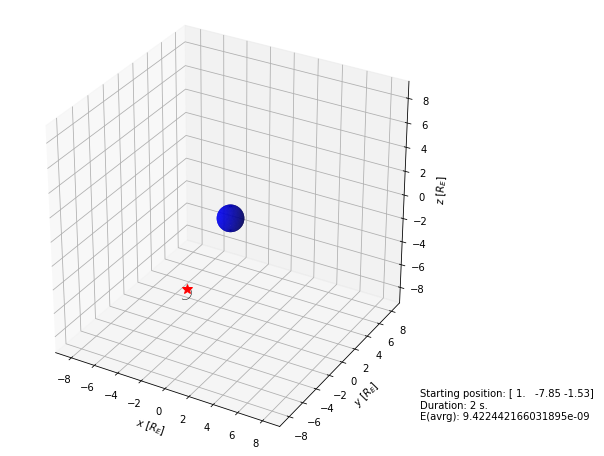

In [109]:
# boris particle tracing
wcount = 0
for i in range(0, steps-1):
    
        r = rdat[i]
        v = vdat[i]
        
        tdat[i] = i*dt

        # compute B-field
        B0 = B(r)

        # compute E-field
        r_geo = np.sqrt(np.dot(r,r))
        theta = np.arccos(r[2]/r_geo)
        phi = np.arctan2(r[0],r[1])

        # warn if particle leaves system
        if r_geo > 5 and wcount == 0 :
                warnings.warn("Exited earth system")
                wcount = 1
        
        E = vs_convection_efield(r_geo, theta, phi, kp, gs)

        # take E value for testing
        edat[i] = E
        
        c0 = (dt*q*B0)/(2*m)
        
        # push step 1 - update velocity with half electrostatic contribution
        v1 = v + (q*E*dt)/(2*m)
        
        # push step 2 - rotated via the magnetic field contribution 
        ax = v1 + np.cross(v1,c0)
        bx = (2*c0)/(1+c0**2)
        v2 = v1 + np.cross(ax,bx)
        
        # push step 3 - updated again with another half of the electrostatic push
        vnew = v2 + (q*E*dt)/(2*m)
        
        # update position
        rnew = r + vnew*dt
        
        # append to data arrays
        vdat[i+1] = vnew
        rdat[i+1] = rnew


fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

# plot dipole field data
ax.plot3D(rdat[:,0],rdat[:,1],rdat[:,2],'k',linewidth=0.5)

# plot starting point
ax.plot(rdat[0][0],rdat[0][1],rdat[0][2],'r',marker='*', markersize=10)

# plot 3D earth
earth3D(1)

# graph correction, keeps origin (0,0,0) at center
ranges = []
ranges.append(math.ceil(max(abs(rdat[:,0]))))
ranges.append(math.ceil(min(abs(rdat[:,0]))))
ranges.append(math.ceil(max(abs(rdat[:,1]))))
ranges.append(math.ceil(min(abs(rdat[:,1]))))
ranges.append(math.ceil(max(abs(rdat[:,2]))))
ranges.append(math.ceil(min(abs(rdat[:,2]))))

axrng = max(ranges)

ax.set_xlim([-axrng, axrng])
ax.set_ylim([-axrng, axrng])
ax.set_zlim([-axrng, axrng])

# plot attributes
ax.set_box_aspect([1,1,1])
ax.set_xlabel("$x$ [$R_E$]")
ax.set_ylabel("$y$ [$R_E$]")
ax.set_zlabel("$z$ [$R_E$]")

# average efield
eavrg = np.mean(edat)

# helpful text
ax.text2D(0.95, 0.05, f"Starting position: {rdat[0]} \nDuration: {tf} s. \nE(avrg): {eavrg}", 
transform=ax.transAxes)

plt.show()


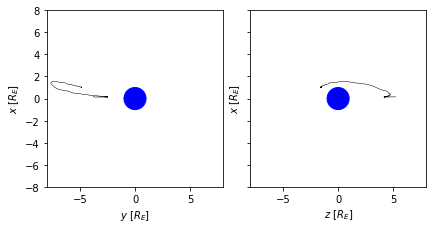

In [83]:
from matplotlib.patches import Circle

fig, ax = plt.subplots(1,2, sharey=True)
fig.tight_layout() 

ax[0].plot(rdat[:,1],rdat[:,0], 'k',linewidth=0.5)
ax[0].set_xlabel("$y$ [$R_E$]")
ax[0].set_ylabel("$x$ [$R_E$]")
ax[0].add_patch(Circle((0,0), 1., color='b', zorder = 10))

# fix axis
ax[0].set_xlim([-axrng, axrng])
ax[0].set_ylim([-axrng, axrng])
ax[0].set_aspect('equal')

ax[1].plot(rdat[:,2],rdat[:,0], 'k',linewidth=0.5)
ax[1].set_xlabel("$z$ [$R_E$]")
ax[1].set_ylabel("$x$ [$R_E$]")
ax[1].add_patch(Circle((0,0), 1., color='b', zorder = 10))

# fix axis
ax[1].set_xlim([-axrng, axrng])
ax[1].set_ylim([-axrng, axrng])
ax[1].set_aspect('equal')





### Refrences
* Volland (1973)
* Stern (1975)
* Ferradas, C. (2017). <i>Understanding Ion Spectral Dynamics Near the Inner Edge Of The Plasma Sheet. https://scholars.unh.edu/dissertation

In [66]:
'''# WIP, IGNORE BELOW'''

def boris(dt, tf, m, q, r0, v0):
    steps = int(tf/dt)

    rdat = np.zeros((steps,3))
    vdat =  np.zeros((steps,3))
    edat = np.zeros((steps,3))
    tdat = np.zeros(steps)

    rdat[0] = r0
    vdat[0] = v0

    for i in range(0, steps-1):
    
        r = rdat[i]
        v = vdat[i]
        
        tdat[i] = i*dt

        # compute B-field
        B0 = B(r)

        # compute E-field
        r_geo = np.sqrt(np.dot(r,r))
        theta = np.arccos(r[2]/r_geo)
        phi = np.arctan2(r[0],r[1])
        
        E = vs_convection_efield(r_geo, theta, phi, kp, gs)

        # take E value for testing
        edat[i] = E
        
        c0 = (dt*q*B0)/(2*m)
        
        # push step 1 - update velocity with half electrostatic contribution
        v1 = v + (q*E*dt)/(2*m)
        
        # push step 2 - rotated via the magnetic field contribution 
        ax = v1 + np.cross(v1,c0)
        bx = (2*c0)/(1+c0**2)
        v2 = v1 + np.cross(ax,bx)
        
        # push step 3 - updated again with another half of the electrostatic push
        vnew = v2 + (q*E*dt)/(2*m)
        
        # update position
        rnew = r + vnew*dt
        
        # append to data arrays
        vdat[i+1] = vnew
        rdat[i+1] = rnew
    
    return rdat, vdat





In [97]:
dt = 0.001
tf = 20

# set initial conditions
r0 = np.array([1., -4.85, -1.53])
v0 = np.array([0.,.12,.2])

'''
# example
r0 = np.array([1., -7.85, -1.53])
v0 = np.array([0.,.3,.3])
'''
# creating charged particle
m = 4.*mp
q = 2.*qe

rdat, vdat = boris(dt, tf, m, q, r0, v0)

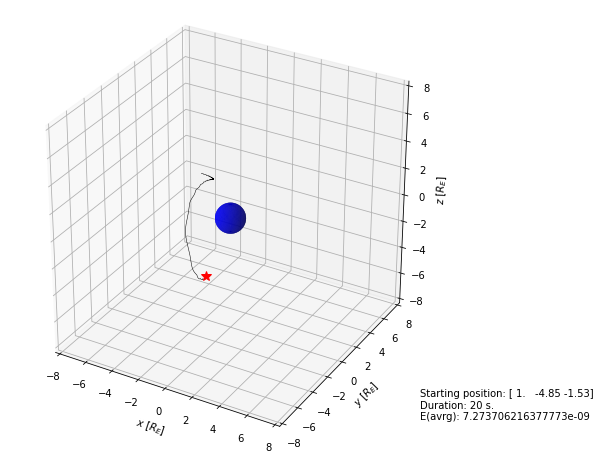

In [98]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

# plot dipole field data
ax.plot3D(rdat[:,0],rdat[:,1],rdat[:,2],'k',linewidth=0.5)

# plot starting point
ax.plot(rdat[0][0],rdat[0][1],rdat[0][2],'r',marker='*', markersize=10)

# plot 3D earth
earth3D(1)

# graph correction, keeps origin (0,0,0) at center
ranges = []
ranges.append(math.ceil(max(abs(rdat[:,0]))))
ranges.append(math.ceil(min(abs(rdat[:,0]))))
ranges.append(math.ceil(max(abs(rdat[:,1]))))
ranges.append(math.ceil(min(abs(rdat[:,1]))))
ranges.append(math.ceil(max(abs(rdat[:,2]))))
ranges.append(math.ceil(min(abs(rdat[:,2]))))

axrng = max(ranges)

ax.set_xlim([-axrng, axrng])
ax.set_ylim([-axrng, axrng])
ax.set_zlim([-axrng, axrng])

# plot attributes
ax.set_box_aspect([1,1,1])
ax.set_xlabel("$x$ [$R_E$]")
ax.set_ylabel("$y$ [$R_E$]")
ax.set_zlabel("$z$ [$R_E$]")

# average efield
eavrg = np.mean(edat)

# helpful text
ax.text2D(0.95, 0.05, f"Starting position: {rdat[0]} \nDuration: {tf} s. \nE(avrg): {eavrg}", 
transform=ax.transAxes)

plt.show()